In [330]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from sklearn.impute import KNNImputer

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))


# Preparación de los datos

In [331]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Ruido_diario_acumulado.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [332]:
# Se obtienen los datos
df_acoustics = pd.read_csv('data/raw/Ruido_diario_acumulado.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


389519

In [333]:
# Se borran los datos no necesarios
df_acoustics = df_acoustics.drop(columns=['LAEQ', 'LAS01', 'LAS10', 'LAS90', 'LAS99'])

df_acoustics.head()


,NMT,anio,mes,dia,tipo,LAS50
0,3,2014,1,1,D,"54,3"
1,3,2014,1,1,E,56
2,3,2014,1,1,N,"60,9"
3,3,2014,1,1,T,"56,5"
4,4,2014,1,1,D,"63,2"


In [334]:
# Se mantiene solo el tipo "T", que representa el total del día
df_acoustics = df_acoustics.drop(df_acoustics[df_acoustics['tipo'] != 'T'].index)

df_acoustics = df_acoustics.drop(columns='tipo')

df_acoustics.head()


,NMT,anio,mes,dia,LAS50
3,3,2014,1,1,"56,5"
7,4,2014,1,1,"63,9"
11,5,2014,1,1,"58,6"
15,8,2014,1,1,"65,2"
19,10,2014,1,1,"58,7"


In [335]:
for date in df_acoustics.columns[1:-1]:
    df_acoustics[date] = list(map(str, df_acoustics[date]))

df_acoustics['date'] = df_acoustics['anio'] + '-' + df_acoustics['mes'] + '-' + df_acoustics['dia']

df_acoustics = df_acoustics.drop(columns=['anio', 'mes', 'dia'])

df_acoustics.head()


,NMT,LAS50,date
3,3,"56,5",2014-1-1
7,4,"63,9",2014-1-1
11,5,"58,6",2014-1-1
15,8,"65,2",2014-1-1
19,10,"58,7",2014-1-1


In [336]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['date'] = pd.to_datetime(df_acoustics['date'])

df_acoustics = df_acoustics.set_index('date')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20'],
              dtype='datetime64[ns]', name='date', length=97522, freq=None)

In [337]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics['LAS50'] = df_acoustics['LAS50'].astype(str)

for col in df_acoustics.columns[1:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = pd.to_numeric(df_acoustics[col], errors='coerce')
    df_acoustics[col] = df_acoustics[col].astype(float)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97522 entries, 2014-01-01 to 2023-03-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NMT     97522 non-null  int64  
 1   LAS50   97522 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [338]:
# Se pivota la tabla para que cada columna sea una zona
df_acoustics = df_acoustics.pivot_table(index='date', columns='NMT', values='LAS50')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,56.5,63.9,58.6,NaN,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,NaN,56.2,48.1,50.5
2014-01-02,NaN,NaN,58.0,64.8,60.0,NaN,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,NaN,60.9,51.6,54.3
2014-01-03,NaN,NaN,58.6,64.7,60.0,NaN,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,NaN,60.6,50.9,54.0
2014-01-04,NaN,NaN,59.0,64.2,59.3,NaN,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,NaN,60.1,50.9,52.8
2014-01-05,NaN,NaN,58.0,63.4,57.8,NaN,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,NaN,58.3,47.9,50.5


In [339]:
# Se establece la frecuencia "D" (diaria)
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       2820 non-null   float64
 1   2       2902 non-null   float64
 2   3       3243 non-null   float64
 3   4       2456 non-null   float64
 4   5       3279 non-null   float64
 5   6       2884 non-null   float64
 6   8       3218 non-null   float64
 7   10      3254 non-null   float64
 8   11      3206 non-null   float64
 9   12      3276 non-null   float64
 10  13      3274 non-null   float64
 11  14      3209 non-null   float64
 12  16      3190 non-null   float64
 13  17      3261 non-null   float64
 14  18      3257 non-null   float64
 15  19      3168 non-null   float64
 16  20      3234 non-null   float64
 17  24      3246 non-null   float64
 18  25      2869 non-null   float64
 19  26      2869 non-null   float64
 20  27      3216 non-null   float64
 21  28      327

In [340]:
# El resto, con una interpolación. Sigue habiendo nulos
df_acoustics = df_acoustics.interpolate(method='spline', order=3)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3001 non-null   float64
 1   2       3000 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3000 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3001 non-null   float64
 19  26      3001 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

In [341]:
# Se imputan los restantes con los vecinos cercanos
imputer = KNNImputer(n_neighbors=5)

imputer.fit(df_acoustics)

df_acoustics = pd.DataFrame(imputer.transform(df_acoustics), columns=df_acoustics.columns, index=df_acoustics.index)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3366 non-null   float64
 1   2       3366 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3366 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3366 non-null   float64
 19  26      3366 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

# Análisis de estacionalidad y estacionaridad

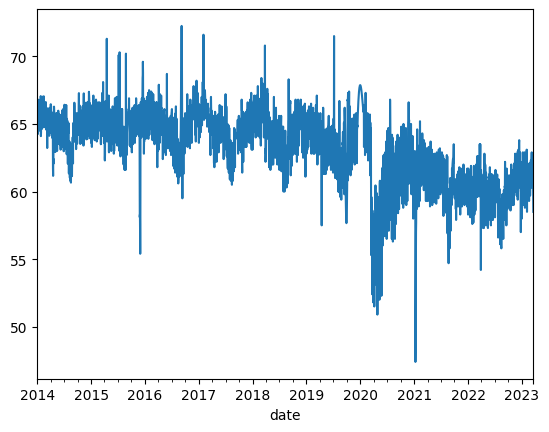

In [342]:
# Se grafica el primero. Hay un cambio de ritmo en 2022
df_acoustics[df_acoustics.columns[0]].plot()
plt.show()


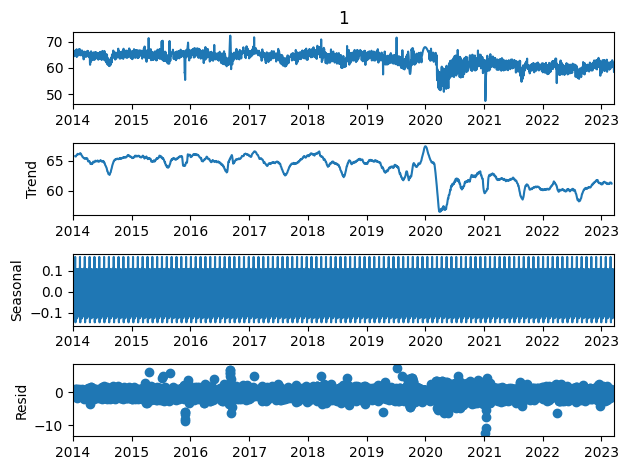

In [343]:
# Descomposición estacional del primero. La estacionalidad es clara. Se confirma que hay un momento con una bajada importante
result = sm.tsa.seasonal_decompose(df_acoustics[df_acoustics.columns[0]], model="additive", period=30).plot()
plt.show()


In [344]:
# Una de las zonas no es estacionaria, pero por poco
p_values = dict()
for zona in df_acoustics.columns:
    dickey_fuller = sts.adfuller(df_acoustics[zona])
    p_value = dickey_fuller[1]
    p_values[zona] = p_value
    if p_value > 0.05:
        print(f'La zona de {zona} no es estacionaria (p valor = {p_value})')


La zona de 4 no es estacionaria (p valor = 0.6122609932236107)


In [346]:
# Se busca el valor mínimo de la tendencia para todas las columnas. El que más se repite tiene la fecha 2020-04-06
for col in df_acoustics.columns:
    ciclo, tendencia = sm.tsa.filters.hpfilter(df_acoustics[col])
    index_min = np.argmin(tendencia)
    df_acoustics.iloc()
    real_index_min = df_acoustics.index[index_min]
    print(real_index_min)


2020-03-31 00:00:00
2020-04-07 00:00:00
2020-04-03 00:00:00
2021-08-14 00:00:00
2020-04-07 00:00:00
2020-05-01 00:00:00
2020-04-05 00:00:00
2020-04-07 00:00:00
2020-04-06 00:00:00
2020-04-06 00:00:00
2020-04-05 00:00:00
2020-04-05 00:00:00
2020-04-04 00:00:00
2020-03-31 00:00:00
2020-03-30 00:00:00
2020-01-16 00:00:00
2021-01-12 00:00:00
2015-02-28 00:00:00
2020-04-07 00:00:00
2020-04-11 00:00:00
2020-04-04 00:00:00
2020-04-06 00:00:00
2020-03-30 00:00:00
2021-01-10 00:00:00
2020-04-06 00:00:00
2020-03-28 00:00:00
2020-05-01 00:00:00
2015-11-12 00:00:00
2020-04-08 00:00:00
2020-04-06 00:00:00
2022-08-16 00:00:00


## Guardado de acoustics

In [ ]:
df_acoustics.to_csv('data/processed/acoustics_days.csv')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,64.60,66.78,56.5,63.9,58.6,66.144368,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,62.28,56.2,48.1,50.5
2014-01-02,66.62,69.28,58.0,64.8,60.0,68.157958,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,65.24,60.9,51.6,54.3
2014-01-03,66.82,69.12,58.6,64.7,60.0,67.897958,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,65.48,60.6,50.9,54.0
2014-01-04,65.66,68.54,59.0,64.2,59.3,67.127979,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,63.92,60.1,50.9,52.8
2014-01-05,64.26,67.22,58.0,63.4,57.8,66.438754,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,62.56,58.3,47.9,50.5


In [ ]:
df_acoustics = pd.read_csv('data/processed/acoustics_days.csv', parse_dates=['date'], index_col='date')
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.head()


,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,64.60,66.78,56.5,63.9,58.6,66.144368,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,62.28,56.2,48.1,50.5
2014-01-02,66.62,69.28,58.0,64.8,60.0,68.157958,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,65.24,60.9,51.6,54.3
2014-01-03,66.82,69.12,58.6,64.7,60.0,67.897958,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,65.48,60.6,50.9,54.0
2014-01-04,65.66,68.54,59.0,64.2,59.3,67.127979,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,63.92,60.1,50.9,52.8
2014-01-05,64.26,67.22,58.0,63.4,57.8,66.438754,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,62.56,58.3,47.9,50.5


# Preprocesado (Holt-Winters)

In [ ]:
df_train = df_acoustics.loc[:'2022-05-31'].copy()
df_test = df_acoustics.loc['2022-06-01':].copy()


In [ ]:
# Se guarda el mejor suavizado para cada columna en un diccionario
r2_dict = dict()
for col in df_train.columns:
    test = df_test[col]
    r2_list = []
    for alpha in np.arange(0.01, 1.01, 0.01).tolist():
        model_simple = SimpleExpSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_double = ExponentialSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_triple = ExponentialSmoothing(df_train[col], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha)
        for model, model_name in [[model_simple, 'model_simple'], [model_double, 'model_double'], [model_triple, 'model_triple']]:
            pred = model.forecast(len(test))
            r2 = r2_score(test, pred)
            r2_list.append([r2, model_name, alpha])
    best = sorted(r2_list, reverse=True)[0]
    r2_dict[col] = best

r2_dict


KeyboardInterrupt: 

In [ ]:
# Se crea un dataframe nuevo de entrenamiento con los datos suavizados para cada zona con el mejor método respectivo
df_train_smoothed = pd.DataFrame({'A' : []})

for key, value in r2_dict.items():
    if value[1] == 'model_simple':
        df_train_smoothed[key] = SimpleExpSmoothing(df_train[key]).fit(smoothing_level=value[2]).fittedvalues
    elif value[1] == 'model_double':
        df_train_smoothed[key] = ExponentialSmoothing(df_train[key]).fit(smoothing_level=value[2]).fittedvalues.shift(-1)
    else:
        df_train_smoothed[key] = ExponentialSmoothing(df_train[key], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=value[2]).fittedvalues

df_train_smoothed = df_train_smoothed.drop(columns='A')

df_train_smoothed.info()


c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3073 entries, 2014-01-01 to 2022-05-31
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3073 non-null   float64
 1   2       3073 non-null   float64
 2   3       3073 non-null   float64
 3   4       3073 non-null   float64
 4   5       3073 non-null   float64
 5   6       3073 non-null   float64
 6   8       3073 non-null   float64
 7   10      3073 non-null   float64
 8   11      3073 non-null   float64
 9   12      3073 non-null   float64
 10  13      3073 non-null   float64
 11  14      3073 non-null   float64
 12  16      3073 non-null   float64
 13  17      3073 non-null   float64
 14  18      3073 non-null   float64
 15  19      3073 non-null   float64
 16  20      3073 non-null   float64
 17  24      3073 non-null   float64
 18  25      3073 non-null   float64
 19  26      3073 non-null   float64
 20  27      3073 non-null   float64
 21  28      307

In [ ]:
# Hay nulos. Se imputan como antes
rolling_mean = df_train_smoothed.rolling(window=30, min_periods=1).mean()

df_train_smoothed = df_train_smoothed.fillna(rolling_mean)

df_train_smoothed.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3073 entries, 2014-01-01 to 2022-05-31
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3073 non-null   float64
 1   2       3073 non-null   float64
 2   3       3073 non-null   float64
 3   4       3073 non-null   float64
 4   5       3073 non-null   float64
 5   6       3073 non-null   float64
 6   8       3073 non-null   float64
 7   10      3073 non-null   float64
 8   11      3073 non-null   float64
 9   12      3073 non-null   float64
 10  13      3073 non-null   float64
 11  14      3073 non-null   float64
 12  16      3073 non-null   float64
 13  17      3073 non-null   float64
 14  18      3073 non-null   float64
 15  19      3073 non-null   float64
 16  20      3073 non-null   float64
 17  24      3073 non-null   float64
 18  25      3073 non-null   float64
 19  26      3073 non-null   float64
 20  27      3073 non-null   float64
 21  28      307

### Guardado df_train_smoothed y df_test

In [ ]:
df_train_smoothed.to_csv('data/processed/train_smoothed_days.csv')
df_test.to_csv('data/processed/test_days.csv')

df_train_smoothed.head()


,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,65.590757,68.123789,57.574568,64.689303,58.988763,67.455268,65.970956,60.474878,66.617039,61.359256,...,61.504578,51.445391,55.407381,54.862572,49.536686,61.450993,62.914236,58.329695,49.527492,52.414987
2014-01-02,65.335530,68.019594,57.563822,64.625344,58.716629,67.298330,65.963247,60.158603,66.604868,61.260727,...,61.409709,51.420938,54.249945,54.839946,49.519319,61.427974,62.562135,58.287101,48.828021,52.266726
2014-01-03,65.720871,68.197693,57.568184,64.607823,59.614989,68.536270,65.978614,60.419207,66.629820,61.415245,...,61.622231,51.418728,56.048463,54.880547,49.534126,61.453414,64.838320,58.339359,50.186291,52.475348
2014-01-04,66.056610,68.313555,57.578502,64.646187,59.884497,68.384003,65.990828,60.574517,66.654521,61.508627,...,61.766642,51.430541,56.857470,54.920741,49.543784,61.478346,65.553748,58.384572,50.536008,52.460753
2014-01-05,65.937627,68.398822,57.592717,64.648167,59.475349,67.790967,66.001920,60.579509,66.661976,61.586544,...,61.753092,51.420236,56.508505,54.971534,49.559346,61.488779,64.165062,58.418881,50.714364,52.518879


In [ ]:
df_train_smoothed = pd.read_csv('data/processed/train_smoothed_days.csv', parse_dates=['date'], index_col='date')
df_test = pd.read_csv('data/processed/test_days.csv', parse_dates=['date'], index_col='date')

df_train_smoothed = df_train_smoothed.asfreq('D')
df_test = df_test.asfreq('D')

df_train_smoothed.head()


,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,65.590757,68.123789,57.574568,64.689303,58.988763,67.455268,65.970956,60.474878,66.617039,61.359256,...,61.504578,51.445391,55.407381,54.862572,49.536686,61.450993,62.914236,58.329695,49.527492,52.414987
2014-01-02,65.335530,68.019594,57.563822,64.625344,58.716629,67.298330,65.963247,60.158603,66.604868,61.260727,...,61.409709,51.420938,54.249945,54.839946,49.519319,61.427974,62.562135,58.287101,48.828021,52.266726
2014-01-03,65.720871,68.197693,57.568184,64.607823,59.614989,68.536270,65.978614,60.419207,66.629820,61.415245,...,61.622231,51.418728,56.048463,54.880547,49.534126,61.453414,64.838320,58.339359,50.186291,52.475348
2014-01-04,66.056610,68.313555,57.578502,64.646187,59.884497,68.384003,65.990828,60.574517,66.654521,61.508627,...,61.766642,51.430541,56.857470,54.920741,49.543784,61.478346,65.553748,58.384572,50.536008,52.460753
2014-01-05,65.937627,68.398822,57.592717,64.648167,59.475349,67.790967,66.001920,60.579509,66.661976,61.586544,...,61.753092,51.420236,56.508505,54.971534,49.559346,61.488779,64.165062,58.418881,50.714364,52.518879


# Modelaje

## ARIMA

### Entrenamiento

In [ ]:
# Se guardan los mejores hiperparámetros, el modelo, la r2 y el mae de cada zona en un diccionario
zone_dict = dict()
for col in df_train_smoothed.columns:
    model = auto_arima(df_train_smoothed[col], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = model.order
    best_seasonal_order = model.seasonal_order
    pred = model.predict(start=len(df_train_smoothed), n_periods=len(df_test))
    test = df_test[col]
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)
    zone_dict[col] = {'params': best_order + best_seasonal_order,
                      'model': model,
                      'r2': r2,
                      'mae': mae
                      }


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3155.653, Time=6.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3657.135, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3447.131, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3354.304, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3655.179, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3174.896, Time=4.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3093.331, Time=1.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3348.451, Time=1.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3256.431, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3086.180, Time=2.00 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3190.263, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3010.025, Time=2.32 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3048.560, Time=0.97 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2922.111, Time=2.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept

KeyboardInterrupt: 

In [ ]:
# Las métricas son las siguientes
zone_dict


{'1': {'params': (5, 2, 2, 0, 0, 0, 0),
  'model': ARIMA(order=(5, 2, 2), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  'r2': -1.1638945525949915,
  'mae': 1.8198393820287722},
 '2': {'params': (2, 2, 3, 0, 0, 0, 0),
  'model': ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  'r2': -0.3913730220877074,
  'mae': 1.3989609612357305},
 '3': {'params': (1, 1, 2, 0, 0, 0, 0),
  'model': ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  'r2': -0.1362165213538542,
  'mae': 0.9459919866841523},
 '4': {'params': (3, 2, 3, 0, 0, 0, 0),
  'model': ARIMA(order=(3, 2, 3), scoring_args={}, suppress_warnings=True),
  'r2': -0.3950048554842407,
  'mae': 1.025916981538863},
 '5': {'params': (1, 1, 2, 0, 0, 0, 0),
  'model': ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  'r2': -0.13163408760488515,
  'mae': 1.0298112787832243},
 '6':